In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import torch 

In [3]:
PATH = os.path.abspath('..')

In [4]:
# get labeled data (excluding test)
label_csv = f'{PATH}/catalogs/SDSSspecgalsDR14_boada.csv'

n = len(list(open(label_csv))) - 1 
val_idxs = get_cv_idxs(n)

# see a few
df = pd.read_csv(label_csv, index_col='objID')
df.head()

,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,...,h_beta_flux,h_beta_flux_err,h_delta_flux,h_delta_flux_err,d4000,d4000_err,bptclass,oh_p50,lgm_tot_p50,sfr_tot_p50
objID,,,,,,,,,,,,,,,,,,,,,
1237657070629027993,460656645643462656,42.848838,-0.087291,0.053164,0.000007,47.39425,13.83830,18.62205,0.039646,17.40391,...,77.06317,2.665140,20.252570,2.762302,1.390432,0.016158,1,8.826264,9.676653,0.130842
1237658203440283667,1440030424800716800,193.603250,48.774640,0.045358,0.000014,56.04235,14.63707,17.95715,0.024831,16.78851,...,33.65274,2.762887,13.318680,3.409556,1.437371,0.024805,1,8.870417,9.774070,0.042070
1237657071157117111,784893009903773696,22.873397,0.336578,0.095072,0.000010,59.03400,12.17910,19.92969,0.067595,18.54727,...,28.92639,1.585112,6.887691,1.785967,1.465837,0.019227,1,9.061250,10.154880,-0.180383
1237657071698378865,1209386973525993472,32.793831,0.631794,0.042327,0.000020,71.91644,20.22402,19.61407,0.085397,18.14444,...,14.20437,1.500584,2.976142,2.110726,1.391771,0.034714,1,8.606583,9.523041,-2.125353
1237657118404903062,1193505347646547968,117.996807,29.413908,0.121984,0.000007,0.00000,55.30409,19.11589,0.043633,18.29203,...,79.92870,2.623430,24.953430,2.327975,1.182455,0.016764,1,8.707049,9.862308,0.482178


In [5]:
id_num = 1237657070629027993
os.path.isfile(f'{PATH}/images/{id_num}.jpg')

True

In [6]:
df.columns

Index(['specObjID', 'ra', 'dec', 'z', 'zErr', 'velDisp', 'velDispErr',
       'modelMag_u', 'modelMagErr_u', 'modelMag_g', 'modelMagErr_g',
       'modelMag_r', 'modelMagErr_r', 'modelMag_i', 'modelMagErr_i',
       'modelMag_z', 'modelMagErr_z', 'petroR50_r', 'petroR90_r',
       'nii_6584_flux', 'nii_6584_flux_err', 'h_alpha_flux',
       'h_alpha_flux_err', 'oiii_5007_flux', 'oiii_5007_flux_err',
       'h_beta_flux', 'h_beta_flux_err', 'h_delta_flux', 'h_delta_flux_err',
       'd4000', 'd4000_err', 'bptclass', 'oh_p50', 'lgm_tot_p50',
       'sfr_tot_p50'],
      dtype='object')

### Examine some of the data

In [7]:
image_ids = [os.path.split(fname)[1].strip('.png') for fname in glob(f'{PATH}/images/*.jpg')]
image_ids[:5]

['1237645879551066262.j',
 '1237645879577936138.j',
 '1237645942905438495.j',
 '1237645943976493208.j',
 '1237645943978328116.j']

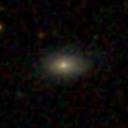

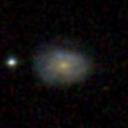

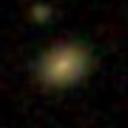

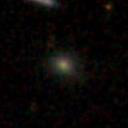

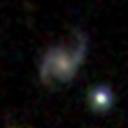

In [8]:
from IPython.display import display
for obj in df.index[:5]:
    display(PIL.Image.open(f'{PATH}/images/{obj}.jpg'))

### Examine distributions of each class

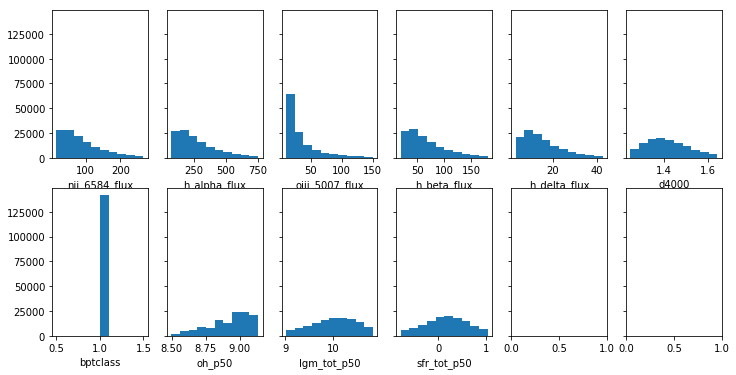

In [9]:
classes = ['nii_6584_flux', 'h_alpha_flux', 'oiii_5007_flux', 'h_beta_flux', 'h_delta_flux', 
           'd4000', 'bptclass', 'oh_p50', 'lgm_tot_p50', 'sfr_tot_p50']

fig, axes = plt.subplots(nrows=2, ncols=len(classes) // 2 + 1, figsize=(12, 6), sharey=True)

for ax, col in zip(axes.flat, classes):
    data = df[col]
    ax.hist(data, range=np.nanpercentile(data, [5, 95]))
    ax.set_xlabel(col)


Let's flag `bptclass` and move on.

## Make a mini training and test sample

I executed the code below to copy a bunch of images to a training set (~10000) and a test set (~5000).

```python
# make a mini training sample of ~15000 images
split_idxs = get_cv_idxs(n, val_pct=20000 / n) 

train_idxs = split_idxs[:-5000]
test_idxs  = split_idxs[-5000:]

# copy files to train-small dir, also make copy of data frame which only has 
# valid images
valid_train_idxs = []
for objid, idx in tqdm_notebook(zip(df.iloc[train_idxs].index, train_idxs), total=len(train_idxs)):
    try:
        shutil.copyfile(f'{PATH}/images/{objid}.jpg', f'{PATH}/train-small/{objid}.jpg')
        valid_train_idxs.append(idx)
    except FileNotFoundError:
        continue

# save mini-dataframe
df_train_small = df.iloc[valid_train_idxs].copy()
df_train_small.to_csv(f'{PATH}/catalogs/train-small.csv')

# do the same thing, except for test-small dataset
valid_test_idxs = []
for objid, idx in tqdm_notebook(zip(df.iloc[test_idxs].index, test_idxs), total=len(test_idxs)):
    try:
        shutil.copyfile(f'{PATH}/images/{objid}.jpg', f'{PATH}/test-small/{objid}.jpg')
        valid_test_idxs.append(idx)
    except FileNotFoundError:
        continue

# save mini-dataframe
df_test_small = df.iloc[valid_test_idxs].copy()
df_test_small.to_csv(f'{PATH}/catalogs/test-small.csv')
```

## Adapt the dataloader for using continuous variable output
Here I used some helper functions defined by @farlion from the fast.ai forums.

In [9]:
def parse_csv_multi_class_values(path_to_csv):
    """Parse filenames and values for classes from a CSV file.

    This method expects that the csv file at path :fn: has one column for filenames,
    while all the other columns represent classes.
    Expects a header with class names

    Arguments:
        path_to_csv: Path to a CSV file.

    Returns:
        a three-tuple of:            
            a list of filenames
            a list of values in the same order
            a dictionary of classes by classIndex           
    """
    with open(path_to_csv) as fileobj:
        reader = csv.reader(fileobj)
        header = next(reader)
        csv_lines = [l for l in reader]

    fnames = [fname for fname, *_ in csv_lines]
    classes = header[1:]
    values = [vals for _, *vals in csv_lines]
    idx2class = {i:c for i, c in enumerate(classes)}
   
    return fnames, values, idx2class

def csv_source_multi_class(folder, csv_file, suffix=''):
    fnames, values, idx2class = parse_csv_multi_class_values(csv_file)
    full_names = [os.path.join(folder,fn+suffix) for fn in fnames]
   
    val_arr = np.array(values).astype(np.float32)
    
    return full_names, val_arr, idx2class

@classmethod
def from_multiclass_csv(cls, path, folder, csv_fname, bs=64, tfms=(None,None),
           val_idxs=None, suffix='', test_name=None, num_workers=8):
    """ Read in images and their labels given as a CSV file.
--
    This method should be used when training image labels are given in an CSV file as opposed to
    sub-directories with label names.

    Arguments:
        path: a root path of the data (used for storing trained models, precomputed values, etc)
        folder: a name of the folder in which training images are contained.
        csv_fname: a name of the CSV file which contains target labels.
        bs: batch size
        tfms: transformations (for data augmentations). e.g. output of `tfms_from_model`
        val_idxs: index of images to be used for validation. e.g. output of `get_cv_idxs`.
            If None, default arguments to get_cv_idxs are used.
        suffix: suffix to add to image names in CSV file (sometimes CSV only contains the file name without file
                extension e.g. '.jpg' - in which case, you can set suffix as '.jpg')
        test_name: a name of the folder which contains test images.
        skip_header: skip the first row of the CSV file.
        num_workers: number of workers

    Returns:
        ImageClassifierData
    """
    fnames,y,idx2class = csv_source_multi_class(folder, csv_fname, suffix)

    val_idxs = get_cv_idxs(len(fnames)) if val_idxs is None else val_idxs
    ((val_fnames,trn_fnames),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), y)

    test_fnames = read_dir(path, test_name) if test_name else None
    
    f = FilesIndexArrayRegressionDataset
    datasets = cls.get_ds(f, (trn_fnames,trn_y), (val_fnames,val_y), tfms,
                           path=path, test=test_fnames)
    return cls(path, datasets, bs, num_workers, classes=list(idx2class.values()))

ImageClassifierData.from_multiclass_csv = from_multiclass_csv

# Train a simple network to predict `oh_p50`

In [12]:
train_label_csv = f'{PATH}/catalogs/metallicity-train-small.csv'
test_label_csv = f'{PATH}/catalogs/metallicity-test-small.csv'

#df_train_small[['oh_p50']].to_csv(train_label_csv)
#df_test_small[['oh_p50']].to_csv(test_label_csv)

df_train_small = pd.read_csv(train_label_csv, index_col='objID')
df_test_small = pd.read_csv(test_label_csv, index_col='objID')

In [13]:
# load in data with transforms
arch = resnet34
sz = 32
bs = 64

In [14]:
val_idxs = get_cv_idxs(len(list(open(train_label_csv))) - 1)

In [15]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'train-small', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-small', 
                    num_workers=4, )

In [16]:
data = get_data(sz, bs)

~~It appears that a batch size of `16` pushes my RAM to the limits (maybe even triggering swap space?), but I don't get an out of memory error -- except when lots of apps are open.~~ Now that I'm using categorical morphology, this seems to be going much more quickly and is light on my memory usage.

In [18]:
# initialize network
learn = ConvLearner.pretrained(arch, data)

[8.999]


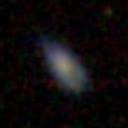

In [19]:
idx = 5 
print(learn.data.trn_y[0])
PIL.Image.open(PATH + '/' + learn.data.trn_ds.fnames[idx])

In [20]:
# find learning rate
lrf=learn.lr_find()

 89%|█████████████████████████████████████████████████████████████▎       | 136/153 [00:06<00:00, 20.30it/s, loss=35.8]


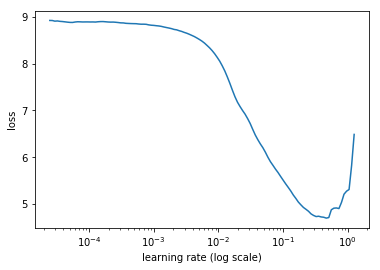

In [21]:
learn.sched.plot()

### Start fitting the los-res images using `rmse` metric
I'm using a learning rate of 0.1.

In [22]:
def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

In [23]:
learn = ConvLearner.pretrained(arch, data)


In [24]:
lr = 0.1
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss                                                                                         
    0      0.695324   0.138136  
    1      0.236631   0.107747                                                                                         
    2      0.129485   0.101359                                                                                         



[array([0.10136])]

In [87]:
learn.save(f'{sz}-small_init-train')

In [25]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.109576   0.098933  
    1      0.114554   0.110665                                                                                         
    2      0.102674   0.095926                                                                                         
    3      0.110724   0.100422                                                                                         
    4      0.10589    0.099885                                                                                         
    5      0.102813   0.093856                                                                                         
    6      0.100032   0.093955                                                                                         



[array([0.09395])]

Looks like loss still has a little ways to go, but we'll move on. Before training on bigger images, let's unfreeze the earlier layers and train them too.

In [26]:
# differential learning rates
learn.unfreeze()

lrs = np.array([1/9, 1/3, 1]) * lr
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.094587   0.084363  
    1      0.097535   0.079423                                                                                         
    2      0.084262   0.075749                                                                                         
    3      0.095239   0.07943                                                                                          
    4      0.090744   0.109299                                                                                         
    5      0.083824   0.074645                                                                                         
    6      0.077653   0.072648                                                                                         



[array([0.07265])]

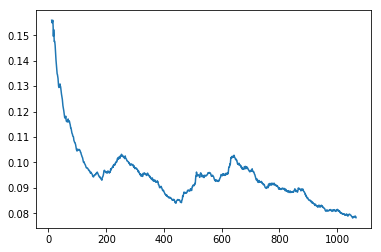

In [27]:
learn.sched.plot_loss()

In [91]:
learn.save(f'{sz}-small_diff-learn-1')

From the look of it, we're still not overfitting yet. In fact, the training `rmse` is *higher* than the crossval `rmse`... Does that mean that we're nowhere near overfitting? 

In [92]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=3)

epoch      trn_loss   val_loss                                
    0      0.080272   0.073689  
    1      0.092796   0.075791                                
    2      0.085211   0.080358                                
    3      0.077751   0.072364                                
    4      0.101213   0.076946                                
    5      0.093605   0.075156                                
    6      0.089903   0.074999                                
    7      0.086707   0.12022                                 
    8      0.081999   0.077015                                
    9      0.079687   0.075953                                
    10     0.076664   0.071229                                
    11     0.074598   0.071449                                
    12     0.07278    0.07087                                 



[array([0.07087])]

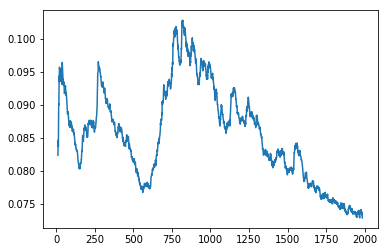

In [93]:
learn.sched.plot_loss()

In [94]:
learn.save(f'{sz}-small_diff-learn-2')

## Examining predictions using the validation set

In [52]:
learn.load(f'{sz}-small_diff-learn-2')

In [78]:
learn.set_data(get_data(sz, bs))
pred = learn.predict()

pred.shape

Validation data examples
Prediction: 8.780, True: 8.672, error: 0.108


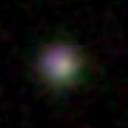

Prediction: 8.903, True: 8.849, error: 0.054


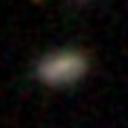

Prediction: 9.076, True: 8.948, error: 0.128


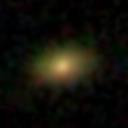

Prediction: 8.976, True: 8.972, error: 0.004


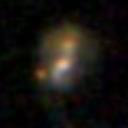

Prediction: 8.883, True: 8.868, error: 0.016


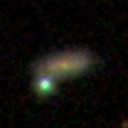

In [125]:
print('Validation data examples')
for i in range(5):
    p, p_val = pred[i, 0], learn.data.val_y[i, 0]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, p_val, np.abs(p-p_val)))
    display(PIL.Image.open(PATH + '/' + learn.data.val_ds.fnames[i]))

### Check test set error distribution

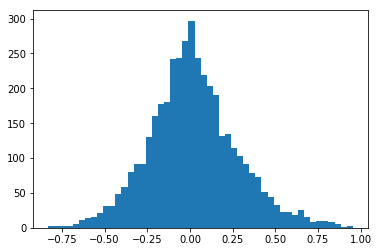

In [97]:
#pred_test = learn.predict(is_test=True)
#y_test = pd.read_csv(test_label_csv).oh_p50

plt.hist((pred_test[:, 0] - y_test), bins=50);

Hm, let's see if we can do better by upgrading the image sizes...

## Continuing using larger image sizes

In [98]:
# doubling up from 32
sz = 64
bs = 64

learn.set_data(get_data(sz, bs))


In [99]:
learn.lr_find()

 88%|████████▊ | 134/153 [00:07<00:01, 18.89it/s, loss=0.618]


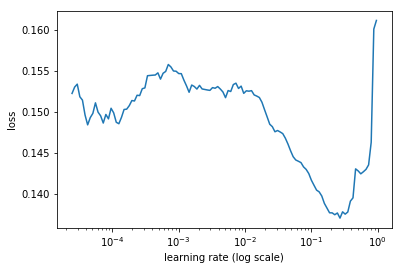

In [100]:
learn.sched.plot()

Stick with 0.1 I guess

In [102]:
lr = 0.1

learn.freeze()
learn.fit(lr, 3)

epoch      trn_loss   val_loss                               
    0      0.124988   0.111054  
    1      0.127541   0.110079                               
    2      0.119074   0.102005                               



[array([0.10201])]

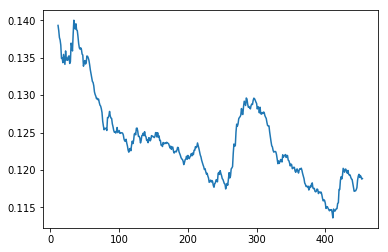

In [103]:
learn.sched.plot_loss()

### Unfreeze early layers again

It looks like training is pretty slow so we'll want to zip things along...

In [104]:
learn.unfreeze()

lrs = np.array([1/9, 1/3, 1]) * lr
learn.fit(lrs, n_cycle=3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                
    0      0.087456   0.075863  
    1      0.087718   0.07536                                 
    2      0.07777    0.071535                                
    3      0.092033   0.092833                                
    4      0.083778   0.070746                                
    5      0.078382   0.068714                                
    6      0.07307    0.068048                                



[array([0.06805])]

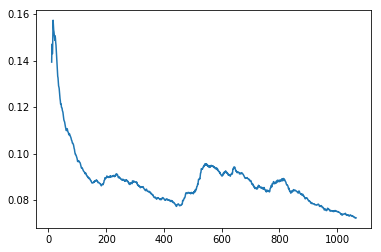

In [105]:
learn.sched.plot_loss()

In [106]:
learn.save(f'32-64-small_diff-learn-1')

### Train for a really long time

In [107]:
learn.fit(lrs, n_cycle=5, cycle_len=2, cycle_mult=3)

epoch      trn_loss   val_loss                                
    0      0.086114   0.109117  
    1      0.077545   0.068627                                
    2      0.088196   0.079596                                
    3      0.086755   0.06989                                 
    4      0.08615    0.080222                                
    5      0.076907   0.069221                                
    6      0.07166    0.067748                                
    7      0.072386   0.067143                                
    8      0.092367   0.091997                                
    9      0.092225   0.069873                                
    10     0.087923   0.107738                                
    11     0.08813    0.083664                                
    12     0.083848   0.130615                                
    13     0.083064   0.071736                                
    14     0.095517   0.119751                                
    15     0.082436   

[array([0.06892])]

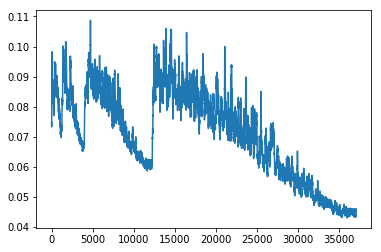

In [120]:
learn.sched.plot_loss()

In [109]:
learn.save(f'32-64-small_diff-learn-2')

Ooh that is pretty.

## Examine results...

### Test data set

In [122]:
pred_test[:, 0] - y_test

array([9.05562, 8.84943, 9.00987, ..., 8.79923, 9.0814 , 8.88461], dtype=float32)

rmse = 0.270


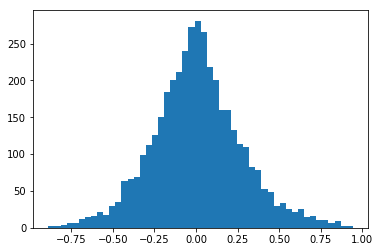

In [130]:
pred_test = learn.predict(is_test=True)
y_test = pd.read_csv(test_label_csv).oh_p50

plt.hist((pred_test[:, 0] - y_test), bins=50);
print('rmse = {:.3f}'.format(np.sqrt(np.mean((pred_test[:, 0] - y_test)**2))))

Test examples
Prediction: 9.056, True: 8.962, error: 0.094


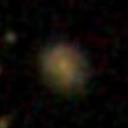

Prediction: 8.849, True: 9.009, error: 0.160


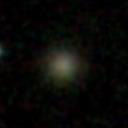

Prediction: 9.010, True: 9.115, error: 0.105


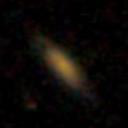

Prediction: 8.706, True: 9.074, error: 0.368


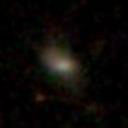

Prediction: 8.848, True: 8.817, error: 0.031


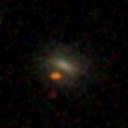

Prediction: 9.088, True: 8.943, error: 0.145


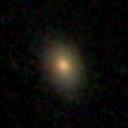

Prediction: 9.041, True: 8.614, error: 0.427


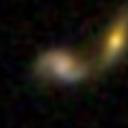

Prediction: 9.129, True: 9.044, error: 0.085


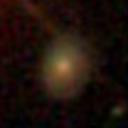

Prediction: 8.928, True: 9.071, error: 0.143


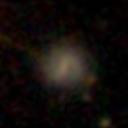

Prediction: 8.941, True: 8.837, error: 0.104


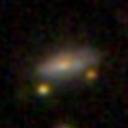

In [146]:
print('Test examples')
for i in range(10):
    p = pred_test[i, 0]
    y = y_test[i]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[i]))

### And here's the validation distribution and examples:

Text(0.5,0,'Validation: O/H p50 rmse [dex]')

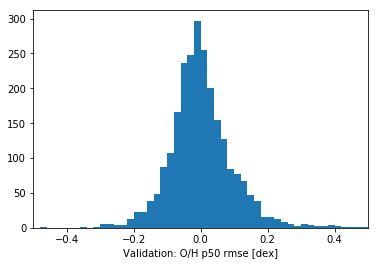

In [231]:
pred_val = learn.predict()
y_val = learn.data.val_y

plt.hist(pred_val[:, 0] - y_val[:, 0], bins=50, range=[-0.5, 0.5])
plt.xlim(-0.5, 0.5)
plt.xlabel('Validation: O/H p50 rmse [dex]')

Validation examples
Prediction: 8.883, True: 8.672, error: 0.211


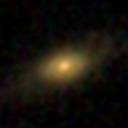

Prediction: 8.877, True: 8.849, error: 0.028


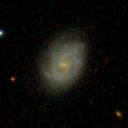

Prediction: 9.011, True: 8.948, error: 0.064


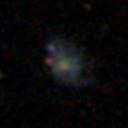

Prediction: 9.048, True: 8.972, error: 0.076


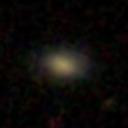

Prediction: 9.019, True: 8.868, error: 0.151


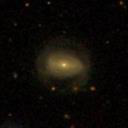

Prediction: 9.004, True: 8.981, error: 0.023


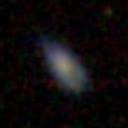

Prediction: 8.766, True: 8.941, error: 0.175


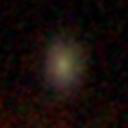

Prediction: 8.821, True: 8.827, error: 0.006


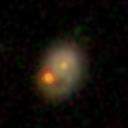

Prediction: 8.875, True: 8.904, error: 0.029


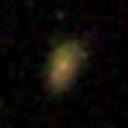

Prediction: 8.793, True: 8.834, error: 0.041


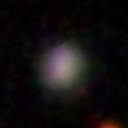

In [147]:
print('Validation examples')
for i in range(10):
    p = pred_val[i, 0]
    y = y_val[i, 0]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.trn_ds.fnames[i]))

### Verdict: valdiation set is overfitting but the test set is still underfitting

## Revisiting the training, validation, and test sets...

In [162]:
df_train_small.describe()

,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,...,h_beta_flux,h_beta_flux_err,h_delta_flux,h_delta_flux_err,d4000,d4000_err,bptclass,oh_p50,lgm_tot_p50,sfr_tot_p50
count,1.222700e+04,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,...,1.222700e+04,1.222700e+04,1.222700e+04,1.222700e+04,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000,12227.000000
mean,1.667780e+18,185.152257,24.847203,0.077230,0.000010,75.094075,21.580320,18.912919,0.044094,17.667671,...,2.930189e+05,1.902071e+04,4.583627e+04,1.714957e+04,1.419935,0.022492,0.999182,8.905440,5.099845,0.159224
std,8.345312e+17,59.764438,18.860278,0.039718,0.000004,53.899241,23.205285,0.721731,0.042091,0.691590,...,2.363153e+07,1.491935e+06,4.072141e+06,1.340847e+06,0.135308,0.011415,0.040437,0.201577,221.676381,0.552963
min,2.996332e+17,0.008745,-11.033890,0.020001,0.000003,0.000000,-3.000000,13.333640,0.004160,13.732440,...,0.000000e+00,-8.361894e-01,-1.055399e+01,-8.361894e-01,0.000000,0.000000,-1.000000,7.868741,-9999.000000,-2.388525
25%,9.317890e+17,151.354917,9.807389,0.047433,0.000007,46.302355,12.169235,18.537775,0.029551,17.341040,...,3.596536e+01,2.063801e+00,7.932601e+00,2.127053e+00,1.336860,0.014684,1.000000,8.806077,9.639602,-0.191246
50%,1.628134e+18,186.179383,23.033745,0.070949,0.000009,72.137850,16.729180,19.020250,0.039757,17.829520,...,5.643927e+01,2.467138e+00,1.307259e+01,2.471609e+00,1.407574,0.019864,1.000000,8.954993,10.053490,0.167783
75%,2.364495e+18,222.066723,39.308092,0.098291,0.000011,99.892370,24.301070,19.387915,0.052258,18.154960,...,9.056501e+01,3.002761e+00,2.138329e+01,2.891865e+00,1.491797,0.027254,1.000000,9.055250,10.415285,0.528295
max,3.348581e+18,359.994814,70.133213,0.346112,0.000106,850.000000,855.236000,23.257640,2.829808,23.079470,...,2.245807e+09,1.258037e+08,4.314945e+08,1.066279e+08,2.281636,0.146004,1.000000,9.468521,12.133280,3.875000


In [161]:
df_test_small.describe()

,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,...,h_beta_flux,h_beta_flux_err,h_delta_flux,h_delta_flux_err,d4000,d4000_err,bptclass,oh_p50,lgm_tot_p50,sfr_tot_p50
count,4.073000e+03,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,4073.000000,...,4.073000e+03,4.073000e+03,4.073000e+03,4.073000e+03,4073.000000,4073.000000,4073.0,4073.000000,4073.000000,4073.000000
mean,1.644073e+18,185.456674,24.976157,0.077434,0.000010,75.796768,21.298009,18.939460,0.043813,17.690321,...,2.359049e+06,6.185987e+04,5.452743e+05,5.773132e+04,1.420123,0.022595,1.0,8.900274,0.174185,0.152249
std,8.295612e+17,59.447800,19.206005,0.040246,0.000005,58.570427,19.726481,0.702359,0.022485,0.675256,...,9.463317e+07,2.291891e+06,2.275165e+07,2.142453e+06,0.138637,0.011242,0.0,0.204327,313.548201,0.563730
min,3.006991e+17,0.368964,-11.202395,0.020043,0.000003,0.000000,-3.000000,15.268890,0.005348,13.803550,...,8.742123e+00,9.763725e-01,-3.309235e+00,-9.469073e-01,0.000000,0.000000,1.0,8.068423,-9999.000000,-3.242641
25%,9.401388e+17,153.247759,9.040233,0.047070,0.000007,46.555230,12.279750,18.577120,0.030322,17.360000,...,3.522792e+01,2.033494e+00,7.879446e+00,2.114387e+00,1.340009,0.014927,1.0,8.801898,9.636093,-0.204086
50%,1.579786e+18,186.887412,23.422236,0.071025,0.000009,72.470530,16.806300,19.040090,0.040458,17.850210,...,5.583730e+01,2.455807e+00,1.300341e+01,2.460729e+00,1.410306,0.020042,1.0,8.954379,10.052280,0.163426
75%,2.352072e+18,222.392381,39.798379,0.098836,0.000011,99.139080,24.462430,19.398720,0.052773,18.162210,...,8.879297e+01,2.984079e+00,2.143197e+01,2.896988e+00,1.491259,0.027504,1.0,9.052958,10.401420,0.509615
max,3.347430e+18,359.894581,69.749572,0.357529,0.000130,850.000000,565.685400,22.211520,0.568070,21.585060,...,4.179097e+09,9.676448e+07,1.083798e+09,9.051342e+07,2.201356,0.115910,1.0,9.364710,12.351170,3.875000


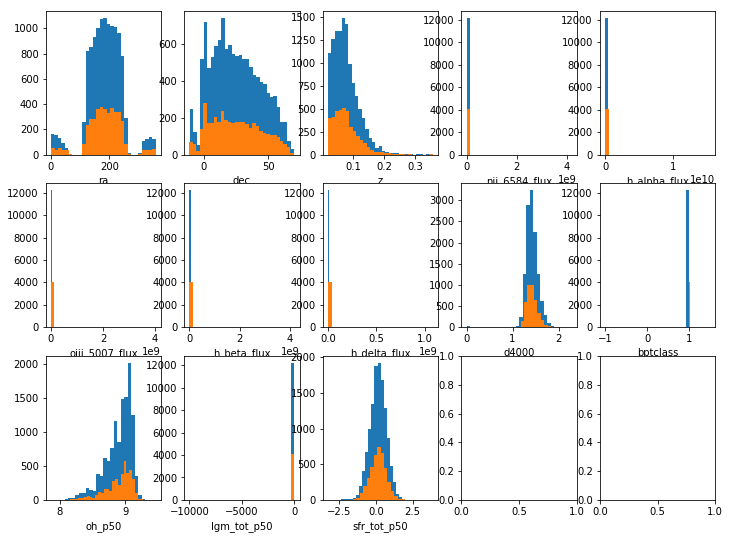

In [165]:
fig, axes = plt.subplots(3, 5, figsize=(12, 9))

details = ['ra', 'dec', 'z']
classes = ['nii_6584_flux', 'h_alpha_flux', 'oiii_5007_flux', 'h_beta_flux', 'h_delta_flux', 
           'd4000', 'bptclass', 'oh_p50', 'lgm_tot_p50', 'sfr_tot_p50']

for ax, col in zip(axes.flat, details+classes):
    ax.set_xlabel(col)
    ax.hist(df_train_small[df_train_small.modelMag_r < 21.0][col], histtype='bar', bins=30)
    ax.hist(df_test_small[df_test_small.modelMag_r < 21.0][col], histtype='bar', bins=30)

Well, aside from the quantities that are limited in dynamic range I think that we are okay here.

### Check if test indices are misaligned in the data loader?

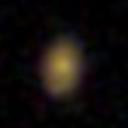

1237666302168334464
Prediction (dataset): 9.096
Truth: 9.100
Indexed: 8.994
-----------------------------------------------------------


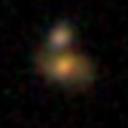

1237667911144308893
Prediction (dataset): 9.068
Truth: 9.247
Indexed: 8.734
-----------------------------------------------------------


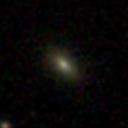

1237654383051800781
Prediction (dataset): 8.521
Truth: 8.742
Indexed: 9.092
-----------------------------------------------------------


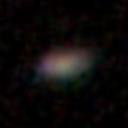

1237652901847236772
Prediction (dataset): 8.819
Truth: 8.677
Indexed: 9.017
-----------------------------------------------------------


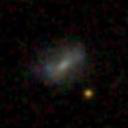

1237660670893359213
Prediction (dataset): 8.717
Truth: 8.658
Indexed: 8.422
-----------------------------------------------------------


In [221]:
for idx in get_cv_idxs(len(df_test_small), val_pct=5 / len(df_test_small)):
    img_name = data.test_ds.fnames[idx]
    img_base = np.int64(os.path.splitext(os.path.basename(img_name))[0])
    img = PIL.Image.open(PATH + '/' + img_name)
    display(img)
    
    print(img_base)
    print('Prediction (dataset): {:.3f}'.format(pred_test[idx, 0]))
    print('Truth: {:.3f}'.format( df_test_small.loc[img_base].oh_p50))
    print('Indexed: {:.3f}'.format(df_test_small.iloc[idx].oh_p50))
    print('-----------------------------------------------------------')

### Looks like the test indices got misaligned from the dataframe's

How did this happen? ~~I need to figure that out...~~ Turns out that the dataframe needs to be sorted by index (see section 1.4.3 below)

rmse = 0.0977


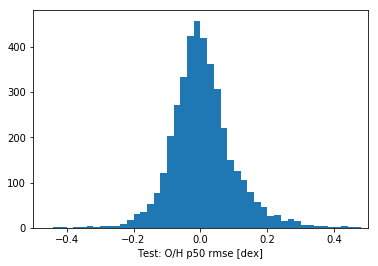

In [233]:
pred_test = learn.predict(is_test=True)

# reorder by image name
img_names = [np.int64(os.path.splitext(os.path.basename(img_name))[0]) for img_name in data.test_ds.fnames]
y_test = df_test_small.loc[img_names].oh_p50

plt.hist((pred_test[:, 0] - y_test), bins=50, range=[-0.5, 0.5])
plt.xlim(-0.5, 0.5)

print('rmse = {:.4f}'.format(np.sqrt(np.mean((pred_test[:, 0] - y_test)**2))))
plt.xlabel('Test: O/H p50 rmse [dex]');

### Fixing the order of the test_label_csv

In [18]:
df_test_small.index

Int64Index([1237658191613919476, 1237664337708449855, 1237670965913715379,
            1237664290460598433, 1237662530060288106, 1237659132205596782,
            1237654601556296132, 1237667911662370941, 1237652944239264043,
            1237660636529361000,
            ...
            1237668292839145563, 1237665025985085670, 1237661069779009839,
            1237657772318589132, 1237665329327046870, 1237650761323577452,
            1237667733963210868, 1237660963479224470, 1237652901819318366,
            1237648720145023063],
           dtype='int64', name='objID', length=4073)

In [24]:
arch = resnet34
val_idxs = get_cv_idxs(len(df_train_small))
data = get_data(64, 64)

img_names = [np.int64(os.path.splitext(os.path.basename(img_name))[0]) for img_name in data.test_ds.fnames]
img_names[:10]

[1237648673994703581,
 1237648673994900138,
 1237648675603284221,
 1237648675605184926,
 1237648675606233649,
 1237648702967119996,
 1237648702975967413,
 1237648702988353742,
 1237648702992417173,
 1237648702994973259]

In [25]:
sorted(df_test_small.index)[:10]

[1237648673994703581,
 1237648673994900138,
 1237648675603284221,
 1237648675605184926,
 1237648675606233649,
 1237648702967119996,
 1237648702975967413,
 1237648702988353742,
 1237648702992417173,
 1237648702994973259]

There we go! What went wrong is that the test image filenames were loaded in alphanumeric order, whereas the dataframe was not. So we just need to sort the data frame by index.

In [28]:
df_test_small.sort_index(inplace=True)
df_test_small.to_csv(test_label_csv)

In [33]:
learn = ConvLearner.pretrained(arch, data)
learn.load('32-64-small_diff-learn-2')

Test examples (again)
Prediction: 9.056, True: 9.105, error: 0.050


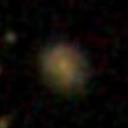

Prediction: 8.849, True: 8.412, error: 0.438


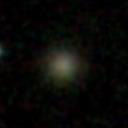

Prediction: 9.010, True: 9.015, error: 0.005


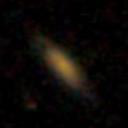

Prediction: 8.706, True: 8.689, error: 0.017


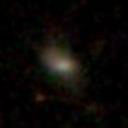

Prediction: 8.848, True: 8.887, error: 0.039


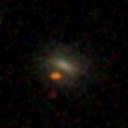

Prediction: 9.088, True: 9.129, error: 0.041


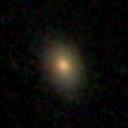

Prediction: 9.041, True: 9.123, error: 0.082


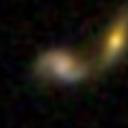

Prediction: 9.129, True: 9.091, error: 0.038


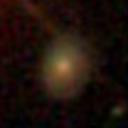

Prediction: 8.928, True: 8.950, error: 0.022


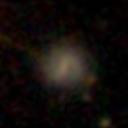

Prediction: 8.941, True: 8.669, error: 0.271


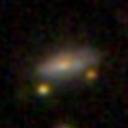

In [38]:
y_test = df_test_small.oh_p50.as_matrix()
pred_test = learn.predict(is_test=True)[:, 0]
print('Test examples (again)')

for i in range(10):
    p = pred_test[i]
    y = y_test[i]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[i]))

0.09769544233074653


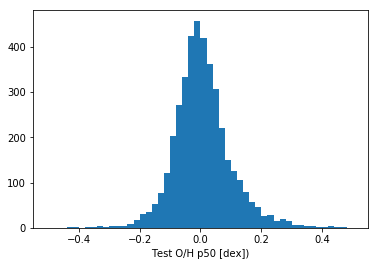

In [40]:
plt.hist(pred_test - y_test, bins=50, range=[-0.5, 0.5])
plt.xlabel('Test O/H p50 [dex])');

print(np.sqrt(np.mean((pred_test - y_test)**2)))

## Larger batch size

 88%|████████████████████████████████████████████████████████████▍        | 134/153 [00:05<00:00, 25.70it/s, loss=22.9]


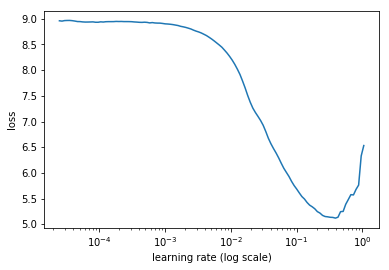

In [46]:
# increase batch size
bs = 128
sz = 32

data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)
learn.crit = rmse



# find learning rate again
learn.lr_find()
learn.sched.plot()

In [47]:
lr = 0.1

learn.fit(lr, n_cycle=5)

epoch      trn_loss   val_loss                                                                                         
    0      0.629408   0.145344  
    1      0.175082   0.143195                                                                                         
    2      0.150999   0.154703                                                                                         
    3      0.149659   0.144997                                                                                         
    4      0.152615   0.128299                                                                                         



[array([0.1283])]

In [48]:
learn.unfreeze()

lrs = np.array([1/9, 1/3, 1]) * lr
learn.fit(lrs, n_cycle=3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.129798   0.111111  
    1      0.124936   0.108907                                                                                         
    2      0.111076   0.102632                                                                                         
    3      0.123488   0.115997                                                                                         
    4      0.121125   0.100961                                                                                         
    5      0.109968   0.100873                                                                                         
    6      0.104616   0.098903                                                                                         



[array([0.0989])]

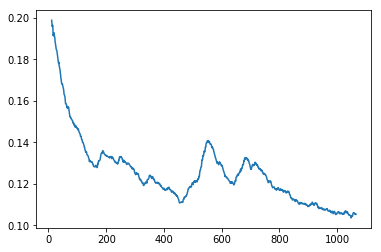

In [49]:
learn.sched.plot_loss()

In [50]:
pred_test = learn.predict(is_test=True)[:, 0]
y_test = df_test_small.oh_p50.as_matrix()

print('Test rmse = {:.4f}'.format(np.sqrt(np.mean((pred_test - y_test)**2))))

Test rmse = 0.1029


### Move up to 64x64

 90%|██████████████████████████████████████████████████████████████▋       | 137/153 [00:07<00:00, 18.83it/s, loss=3.3]


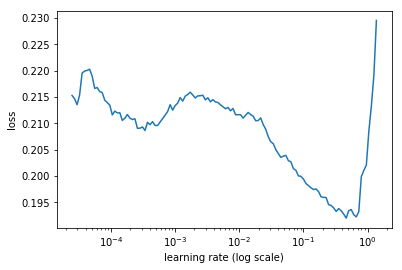

In [51]:
learn.set_data(get_data(64, bs))
learn.lr_find()
learn.sched.plot()

In [52]:
learn.freeze()
lr = 0.1
learn.fit(lr, 3)

epoch      trn_loss   val_loss                                                                                         
    0      0.167496   0.143164  
    1      0.165844   0.142985                                                                                         
    2      0.16399    0.167678                                                                                         



[array([0.16768])]

In [55]:
lrs = lr * np.array([1/9, 1/3, 1])
learn.unfreeze()
learn.fit(lrs, n_cycle=3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.120297   0.102272  
    1      0.121704   0.154063                                                                                         
    2      0.108      0.096383                                                                                         
    3      0.131545   0.127069                                                                                         
    4      0.120008   0.100636                                                                                         
    5      0.108702   0.094519                                                                                         
    6      0.103138   0.092957                                                                                         



[array([0.09296])]

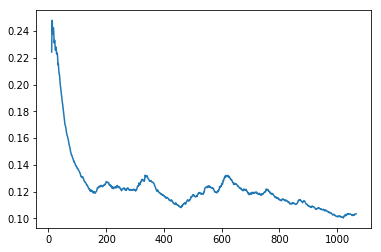

In [56]:
learn.sched.plot_loss()

epoch      trn_loss   val_loss                                                                                         
    0      0.123415   0.108005  
    1      0.124575   0.118362                                                                                         
    2      0.121957   0.119232                                                                                         
    3      0.113745   0.120736                                                                                         
    4      0.115239   0.111589                                                                                         



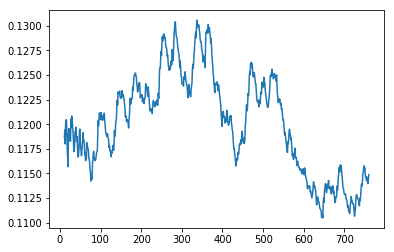

In [57]:
learn.fit(lrs, 5)
learn.sched.plot_loss()

In [58]:
learn.fit(lrs, n_cycle=3, cycle_len=1, cycle_mult=3)

epoch      trn_loss   val_loss                                                                                         
    0      0.1059     0.09655   
    1      0.118548   0.100301                                                                                         
    2      0.108648   0.096298                                                                                         
    3      0.099088   0.093017                                                                                         
    4      0.119811   0.11019                                                                                          
    5      0.12092    0.092102                                                                                         
    6      0.116392   0.112457                                                                                         
    7      0.112769   0.105588                                                                                         
    8  

[array([0.09248])]

## Next steps?

- Perhaps we can make a pipeline moving from 32 -> 64 -> 128, with batchsize ~ 128? 
- We can also add more data (rather than ~10^4 galaxies, throw ~10^5 at it). 
- Another option is to use ResNet50 or Resnet101.

# Use more data

In [28]:
train_label_csv = f'{PATH}/catalogs/train.csv'
df = pd.read_csv(train_label_csv, index_col=0)

val_idxs = get_cv_idxs(len(df))

### Create test-train split

```python
# randomly do ~80/20 split
split_idxs = np.arange(len(df))
np.random.shuffle(split_idxs)

train_idxs = split_idxs[:-25000]
test_idxs  = split_idxs[-25000:]

# copy files to train-small dir, also make copy of data frame which only has 
# valid images
valid_train_idxs = []
for objid, idx in tqdm_notebook(zip(df.iloc[train_idxs].index, train_idxs), total=len(train_idxs)):
    try:
        shutil.copyfile(f'{PATH}/images/{objid}.jpg', f'{PATH}/train/{objid}.jpg')
        valid_train_idxs.append(idx)
    except FileNotFoundError:
        continue

# save mini-dataframe
df_train = df.iloc[valid_train_idxs].copy()
df_train.to_csv(f'{PATH}/catalogs/train.csv')

# do the same thing, except for test-small dataset
valid_test_idxs = []
for objid, idx in tqdm_notebook(zip(df.iloc[test_idxs].index, test_idxs), total=len(test_idxs)):
    try:
        shutil.copyfile(f'{PATH}/images/{objid}.jpg', f'{PATH}/test/{objid}.jpg')
        valid_test_idxs.append(idx)
    except FileNotFoundError:
        continue

# save mini-dataframe *and sort by index*
df_test = df.iloc[valid_test_idxs].copy()
df_test.sort_index(inplace=True)
df_test.to_csv(f'{PATH}/catalogs/test.csv')
```

### Initialize network

In [80]:
sz = 32
bs = 64
arch = resnet34

def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    return ImageClassifierData.from_multiclass_csv(PATH, 'images', train_label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test', num_workers=4, )

 81%|███████████████████████████████████████████████████████▏            | 973/1200 [00:38<00:09, 24.99it/s, loss=1.99]

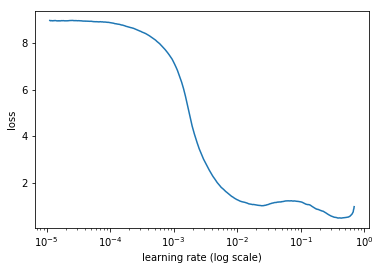

 81%|███████████████████████████████████████████████████████▏            | 973/1200 [00:50<00:11, 19.46it/s, loss=1.99]

In [30]:
data = get_data(sz, bs)
learn = ConvLearner.pretrained(arch, data)

def rmse(x, y):
    return torch.sqrt(F.mse_loss(x,y))

metrics = [rmse]
learn.crit = rmse

learn.lr_find()
learn.sched.plot()

## Early training

~~Let's be adventurous and select a high learning rate of 0.3~~ $\leftarrow$ too high, that started to diverge.

~~Let's try a learning rate of 3e-3.~~ $\leftarrow$ too low, that took over 5 epochs to make it to RMSE = 0.10.

Perhaps let's try lr=0.1 again?

In [31]:
lr = 0.1
learn.fit(lr, 5, cycle_len=1)

epoch      trn_loss   val_loss                                                                                         
    0      0.129876   0.126688  
    1      0.127225   0.12521                                                                                          
    2      0.130174   0.12305                                                                                          
    3      0.127036   0.122604                                                                                         
    4      0.128583   0.122967                                                                                         


[array([0.12297])]

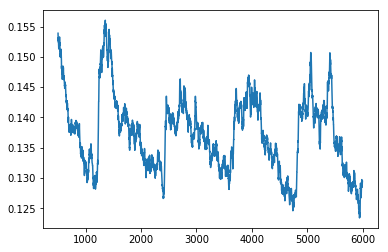

In [34]:
learn.sched.plot_loss(n_skip=500)

In [37]:
learn.unfreeze()

# lower the rate a little
lrs = 3e-2 * np.array([1/9, 1/3, 1])

learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.106979   0.097168  
    1      0.114962   0.120366                                                                                         
    2      0.100874   0.09285                                                                                          
    3      0.120219   0.117999                                                                                         
    4      0.115176   0.135177                                                                                         
    5      0.098762   0.099988                                                                                         
    6      0.097793   0.091964                                                                                         


[array([0.09196])]

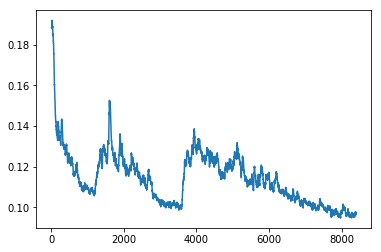

In [38]:
learn.sched.plot_loss()

In [39]:
learn.save('32_diff-1')

In [40]:
# anneal more?
lrs = 1e-2 * np.array([1/16, 1/4, 1])
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                                                                         
    0      0.095354   0.091533  
    1      0.097515   0.092917                                                                                         
    2      0.09679    0.092624                                                                                         
    3      0.099933   0.089648                                                                                         
    4      0.098405   0.090178                                                                                         
    5      0.096669   0.09102                                                                                          
    6      0.098523   0.094043                                                                                         


[array([0.09404])]

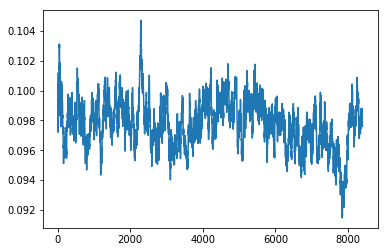

In [41]:
learn.sched.plot_loss()

In [42]:
learn.save('32_diff-2')

## 64-size training

In [44]:
learn.load('32_diff-2')

epoch      trn_loss   val_loss                                                                                         
    0      0.126477   0.113261  
    1      0.127764   0.110876                                                                                         
    2      0.122359   0.109994                                                                                         
    3      0.139366   0.145778                                                                                         
    4      0.126322   0.132013                                                                                         
    5      0.121149   0.108713                                                                                         
    6      0.121518   0.111562                                                                                         


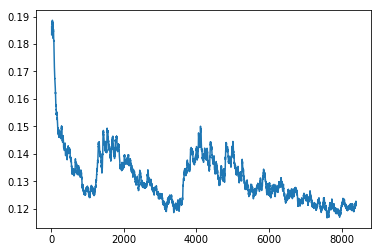

In [46]:
data = get_data(64, 128)
learn.set_data(data)

learn.freeze()

lr = 0.1
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)
learn.sched.plot_loss()

In [47]:
learn.save('32-64_init')

In [48]:
# unfreeze and train more
learn.unfreeze()

lrs = 0.01 * np.array([1/25, 1/5, 1])

learn.fit(lr, 5, cycle_len=1, cycle_mult=2)


epoch      trn_loss   val_loss                                                                                         
    0      0.098274   0.088927  
    1      0.107666   0.100775                                                                                         
    2      0.09463    0.086893                                                                                         
    3      0.114999   0.095891                                                                                         
    4      0.103629   0.091892                                                                                         
    5      0.098478   0.105339                                                                                         
    6      0.095428   0.086725                                                                                         
    7      0.119496   0.08948                                                                                          
    8  

KeyboardInterrupt: 

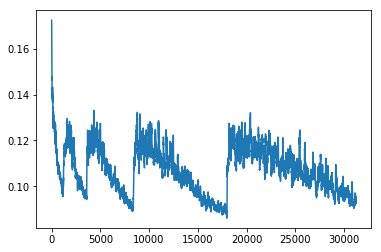

In [49]:
learn.sched.plot_loss()

In [50]:
#learn.save('32-64_diff-1')
learn.load('32-64_diff-1')

## Evaluation time

### Check validation set using test-time augmentation (TTA)

In [51]:
logp, y_val = learn.TTA()

Prediction: 8.725, True: 8.740, error: 0.015


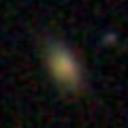

Prediction: 9.056, True: 9.104, error: 0.048


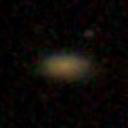

Prediction: 9.088, True: 9.041, error: 0.047


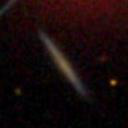

Prediction: 8.974, True: 8.949, error: 0.025


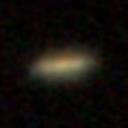

Prediction: 8.328, True: 8.205, error: 0.123


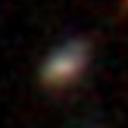

Prediction: 8.985, True: 9.011, error: 0.025


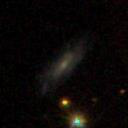

Prediction: 8.707, True: 8.668, error: 0.039


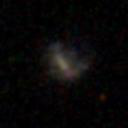

Prediction: 8.802, True: 8.668, error: 0.134


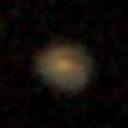

Prediction: 8.359, True: 8.382, error: 0.023


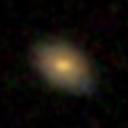

Prediction: 8.960, True: 8.910, error: 0.050


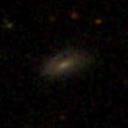

In [52]:
p_val = np.mean(logp, axis=0)

for i in range(10):
    p = p_val[i, 0]
    y = y_val[i, 0]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[i]))

Val accuracy (with TTA) is 0.083


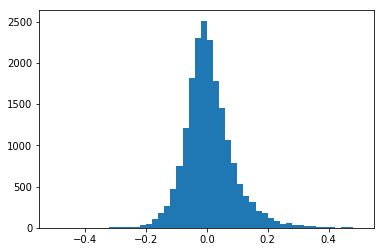

In [53]:
plt.hist(p_val[:,0] - y_val[:,0], bins=50, range=[-0.5, 0.5]);

print('Val accuracy (with TTA) is {:.3f}'.format(np.sqrt(np.mean((p_val[:,0] - y_val[:,0])**2))))

### In the "eyes" of the resnet, which objects have the lowest or highest metallicity?

The lowest metallicity:

Prediction: 8.107, True: 8.100, error: 0.007


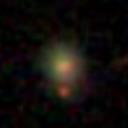

Prediction: 8.107, True: 8.212, error: 0.105


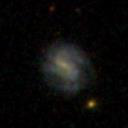

Prediction: 8.111, True: 7.896, error: 0.215


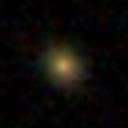

Prediction: 8.143, True: 8.052, error: 0.092


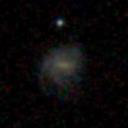

Prediction: 8.153, True: 8.141, error: 0.011


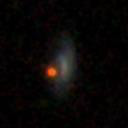

Prediction: 8.153, True: 8.209, error: 0.056


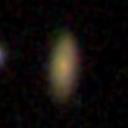

Prediction: 8.157, True: 8.162, error: 0.005


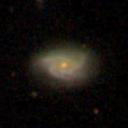

Prediction: 8.161, True: 7.997, error: 0.164


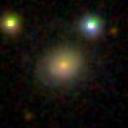

Prediction: 8.161, True: 7.869, error: 0.293


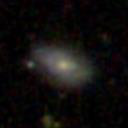

Prediction: 8.161, True: 8.092, error: 0.069


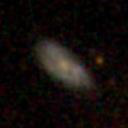

In [71]:
for [idx] in np.argsort(p_val, axis=0)[:10]:
    p = p_val[idx, 0]
    y = y_val[idx, 0]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

Prediction: 9.297, True: 9.080, error: 0.217


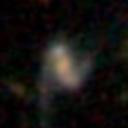

Prediction: 9.239, True: 9.369, error: 0.130


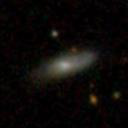

Prediction: 9.205, True: 9.117, error: 0.087


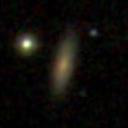

Prediction: 9.201, True: 9.230, error: 0.029


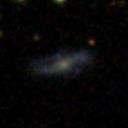

Prediction: 9.198, True: 9.254, error: 0.056


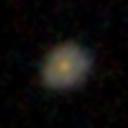

Prediction: 9.189, True: 9.110, error: 0.078


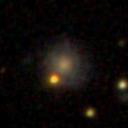

Prediction: 9.176, True: 9.250, error: 0.074


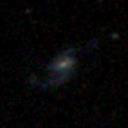

Prediction: 9.167, True: 9.149, error: 0.017


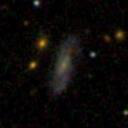

Prediction: 9.165, True: 9.136, error: 0.029


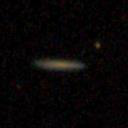

In [75]:
for [idx] in np.argsort(p_val, axis=0)[:-10:-1]:
    p = p_val[idx, 0]
    y = y_val[idx, 0]
    print('Prediction: {:.3f}, True: {:.3f}, error: {:.3f}'.format(p, y, np.abs(p-y)))
    display(PIL.Image.open(PATH + '/' + learn.data.test_ds.fnames[idx]))

### Evaluate using test dataset

This takes a while because there are about 20000 test images! Thus I'm using `learn.predict` rather than `learn.TTA` -- even though the latter would yield slightly better results.

In [82]:
p_test = learn.predict(is_test=True)

Test (no TTA) rmse is = 0.086


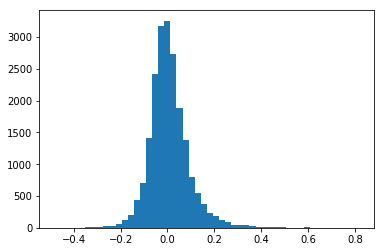

In [84]:
test_label_csv = f'{PATH}/catalogs/test.csv'
y_test = pd.read_csv(test_label_csv).oh_p50

plt.hist((p_test[:, 0] - y_test), bins=50);
print('Test (no TTA) rmse is = {:.3f}'.format(np.sqrt(np.mean((p_test[:, 0] - y_test)**2))))